In [1]:
!pip install livelossplot

# ACSE-8 Afternoon 6 Exercise

We do not have any exercises planned for Autoencoders/GANs. 

Feel free to use this afternoon to continue to work on your coursework submission due on Monday. 

If you have finished the coursework and are looking for another challenge, here's a code Olivier referenced in his RNN class. In the following code (adapted from [here](https://machinetalk.org/2019/02/08/text-generation-with-pytorch/)), we will train a model to generate text _in the style of_ the Harry Potter books. For this, we have provided you a text file _harry.txt_ which contains the full text of the first book - _Harry Potter and the Sorcerer's Stone_ (yes, unfortunately it is the American version).


First, we define our imports and some parameters.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from collections import Counter
import os
from argparse import Namespace


flags = Namespace(
    train_file='harry.txt',
    seq_size=32,
    batch_size=16,
    embedding_size=64,
    lstm_size=64,
    gradients_norm=5,
    initial_words=['I', 'am'],
    predict_top_k=5,
    checkpoint_path='checkpoint',
)

Next, we define some helper functions, first to load data from file,

In [ ]:
def get_data_from_file(train_file, batch_size, seq_size):
    with open(train_file, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    text = text.split()

    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    print('Vocabulary size', n_vocab)

    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text

...and the next one to divide the data into batches:

In [ ]:
def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

Now we define the RNN. [Look here](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html) for an understanding of what an Embedding is and what it is doing for us here. 

In [ ]:
class RNNModule(nn.Module):
    def __init__(self, n_vocab, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state

    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))

Some (last minute) hyperparameters:

In [ ]:
def get_loss_and_train_op(net, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    return criterion, optimizer

Some housekeeping before we get started (the embedding size and lstm size are good targets for hyperparameter optimisation later)

In [29]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(
    flags.train_file, flags.batch_size, flags.seq_size)

net = RNNModule(n_vocab, flags.embedding_size, flags.lstm_size)

net = net.to(device)

criterion, optimizer = get_loss_and_train_op(net, 0.01)

iteration = 0

Vocabulary size 11895


Finally we are ready to start training.

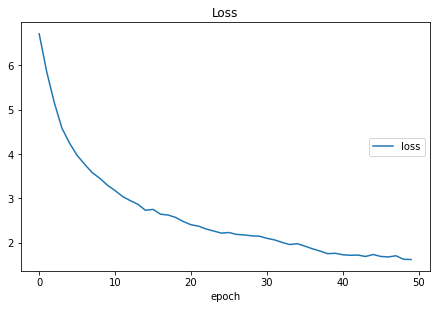

Loss
	loss             	 (min:    1.620, max:    8.836, cur:    1.620)


In [36]:
from livelossplot import PlotLosses

liveloss = PlotLosses()
logs = {}
for e in range(50):
        batches = get_batches(in_text, out_text, flags.batch_size, flags.seq_size)
        state_h, state_c = net.zero_state(flags.batch_size)
        
        # Transfer data to GPU
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        for x, y in batches:
            iteration += 1
            
            # Tell it we are in training mode
            net.train()

            # Reset all gradients
            optimizer.zero_grad()

            # Transfer data to GPU
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss_value = loss.item()

            # Perform back-propagation
            loss.backward()

            _ = torch.nn.utils.clip_grad_norm_(
                net.parameters(), flags.gradients_norm)

            # Update the network's parameters
            optimizer.step()

        logs['loss'] = loss_value
        liveloss.update(logs)
        liveloss.draw()

With the model trained, we can finally get to the best part: Generating text! This function samples from the output distribution of our trained model to generate text. Try it out yourself in the next cell. 

In [ ]:
from textwrap import fill


def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0]) # Could be improved

    words.append(int_to_vocab[choice])

    for _ in range(100):
        ix = torch.tensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0]) # Could be improved
        words.append(int_to_vocab[choice])

    print(fill(' '.join(words), 100))

Here comes the fun. Enter any two "seed words" in the next cell to get the model to generate some text starting with those words. 

You might notice that the initial model does not produce very good text. Here's some things that could be improved:
 - The sampling bit of the predict function in the above cell doesn't seem to be doing a great job at sampling from the posterior distribution. Can you improve it? (Remember: You don't need to retrain to see improvements from this)
 - Using the final value of the loss to guide you, can you find better values for the embedding size/lstm size hyperparameters above?

In [54]:
predict(device, net, ["Lord", "Voldemort"], n_vocab, vocab_to_int, int_to_vocab)

Lord Voldemort got out, clapped loudest. by one, and then came pelting out onto their way through
the barrier. It yelled in her mouth, perhaps Hogwarts. The old man pulled the other day were
learning old enough, passed Professor McGonagall was still safe. toward himself on it and he was
looking forward through his eyes. "A note wasn't much space from being corridors with one of their
men was guarding three of them started to drift Hagrid's jacket and an empty except Harry had gone
only joking, I never told them what this wasn't inside all as your family's one of the red-haired
